#### Step 1 : Import libraries

In [1]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt
from skimage.io import imread
from scipy.ndimage import gaussian_filter
from scipy import signal as sig

C:\ProgramData\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


Note: 
1. Value of k lies in range(0.04, 0.06)
2. When |R| is small, which happens when λ1 and λ2 are small, the region is flat.
3. When R<0, which happens when λ1>>λ2 or vice versa, the region is edge.
4. When R is large, which happens when λ1 and λ2 are large and λ1~λ2, the region is a corner.

#### Step 2 : Harris Corner Detection 

In [2]:
def convolve2D(image, kernel):
    height, width = image.shape
    k_height, k_width = kernel.shape
    pad_height, pad_width = k_height // 2, k_width // 2

    # Pad the image
    padded_image = np.pad(image, ((pad_height, pad_height), (pad_width, pad_width)), mode='constant')

    # Convolution operation
    output = np.zeros_like(image)
    for i in range(height):
        for j in range(width):
            output[i, j] = np.sum(padded_image[i:i + k_height, j:j + k_width] * kernel)

    return output

In [3]:
def harris_corner_detector(image, window_size=3, k=0.04):
    # Convert image to grayscale
    if len(image.shape) < 3:
        imggray = image
    else:
        imggray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    
    # Compute derivatives using Sobel operator
    kernel_x = np.array([[-1, 0, 1],[-2, 0, 2],[-1, 0, 1]])
    Ix = sig.convolve2d(imggray, kernel_x, mode='same')
    kernel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
    Iy = sig.convolve2d(imggray, kernel_y, mode='same')
    
    ## Using in-built function
    #Ix = cv2.Sobel(imggray, cv2.CV_64F, 1, 0, ksize=3)
    #Iy = cv2.Sobel(imggray, cv2.CV_64F, 0, 1, ksize=3)
    
    # Compute elements of the Harris matrix M
    Ix2 = Ix ** 2
    Iy2 = Iy ** 2
    Ixy = Ix * Iy
    
    # Compute sums of the elements in the window
    Sxx = gaussian_filter(Ix2, window_size)
    Syy = gaussian_filter(Iy2, window_size)
    Sxy = gaussian_filter(Ixy, window_size)
    
    # Compute the determinant and trace of M for each pixel
    det_M = (Sxx * Syy) - (Sxy ** 2)
    trace_M = Sxx + Syy
    
    # Compute corner response R
    R = det_M - k * (trace_M ** 2)
    print(type(R))
    print(np.max(R), np.min(R), np.mean(R), np.median(R))
    print(R)
    
    # Threshold Corner Response: Apply thresholding to find corners
    #corners = np.zeros_like(R)
    #corners[R > threshold] = 255 
    
    return R

#### Step 3 : Plot the corners

In [50]:
def harris_corners(image, threshold, **kwargs):
    img_copy_for_corners = np.copy(image)
    corner_response = harris_corner_detector(image, **kwargs)

    for rowindex, response in enumerate(corner_response):
        for colindex, r in enumerate(response):
            if r > threshold:
                # this is a corner, assign red color
                #img_copy_for_corners[rowindex, colindex] = [255,0,0]  # Red color in grayscale
                img_copy_for_corners[rowindex, colindex] = 255

    return img_copy_for_corners

In [32]:
def compare_results(image, threshold, block_size, ksize, **kwargs):    
    # Apply Harris Corner detection
    custom_corners = harris_corners(image, threshold, **kwargs)
    plt.subplot(1, 2, 1)
    plt.imshow(custom_corners, cmap='bwr_r')
    plt.title('Custom Harris Corner Detection', fontsize=11)
    
    # Using OpenCV's corner detection
    ## Convert the input image to grayscale
    if len(image.shape) < 3:
        gray_image = image
    else:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY).astype(np.float32)
    
    cv_corners = cv2.cornerHarris(gray_image, blockSize=block_size, ksize=ksize, k=0.04) 
    plt.subplot(1, 2, 2)
    plt.imshow(cv_corners, cmap='bwr_r')
    plt.title('OpenCV Harris Corner Detection', fontsize=11)
    
    plt.show()

#### Step 4 : Comparison

##### Img 1

In [6]:
dir = 'Assignment 1/Question 1/'

<class 'numpy.ndarray'>
82734829035.77966 -6105266600.006076 -207465292.3167182 0.0
[[8.27348290e+10 6.92113924e+10 4.54683628e+10 ... 4.54683628e+10
  6.92113924e+10 8.27348290e+10]
 [6.92113924e+10 5.80570978e+10 3.85199781e+10 ... 3.85199781e+10
  5.80570978e+10 6.92113924e+10]
 [4.54683628e+10 3.85199781e+10 2.60716084e+10 ... 2.60716084e+10
  3.85199781e+10 4.54683628e+10]
 ...
 [4.54683628e+10 3.85199781e+10 2.60716084e+10 ... 2.60716084e+10
  3.85199781e+10 4.54683628e+10]
 [6.92113924e+10 5.80570978e+10 3.85199781e+10 ... 3.85199781e+10
  5.80570978e+10 6.92113924e+10]
 [8.27348290e+10 6.92113924e+10 4.54683628e+10 ... 4.54683628e+10
  6.92113924e+10 8.27348290e+10]]


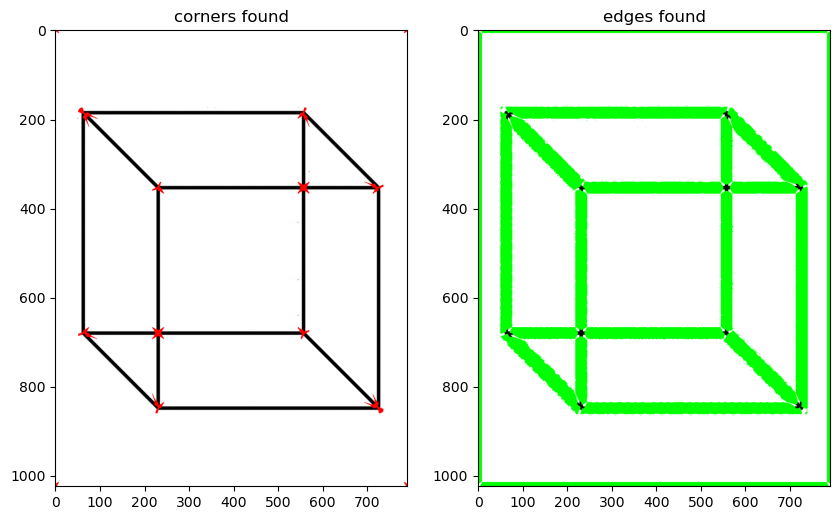

In [7]:
# Read the image
image = imread(dir+'1.gif')

img_copy_for_corners = np.copy(image)
img_copy_for_edges = np.copy(image)

custom_corners = harris_corner_detector(image,2)

for rowindex, response in enumerate(custom_corners):
    for colindex, r in enumerate(response):
        if r > 20:
            # this is a corner
            img_copy_for_corners[rowindex, colindex] = [255,0,0]
        elif r < 0:
            # this is an edge
            img_copy_for_edges[rowindex, colindex] = [0,255,0]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,10))
ax[0].set_title("corners found")
ax[0].imshow(img_copy_for_corners)
ax[1].set_title("edges found")
ax[1].imshow(img_copy_for_edges)
plt.show()

<class 'numpy.ndarray'>
46347337135.49512 -2899549721.7085567 -148797679.08160272 0.0
[[4.63473371e+10 4.22741259e+10 3.48263539e+10 ... 3.48263539e+10
  4.22741259e+10 4.63473371e+10]
 [4.22741259e+10 3.85973209e+10 3.18659714e+10 ... 3.18659714e+10
  3.85973209e+10 4.22741259e+10]
 [3.48263539e+10 3.18659714e+10 2.64233692e+10 ... 2.64233692e+10
  3.18659714e+10 3.48263539e+10]
 ...
 [3.48263539e+10 3.18659714e+10 2.64233692e+10 ... 2.64233692e+10
  3.18659714e+10 3.48263539e+10]
 [4.22741259e+10 3.85973209e+10 3.18659714e+10 ... 3.18659714e+10
  3.85973209e+10 4.22741259e+10]
 [4.63473371e+10 4.22741259e+10 3.48263539e+10 ... 3.48263539e+10
  4.22741259e+10 4.63473371e+10]]


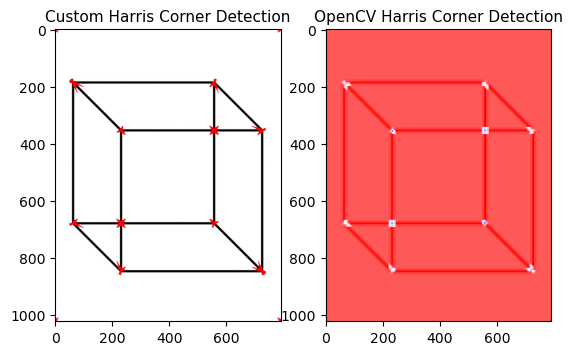

In [9]:
compare_results(image, 15000, block_size=15, ksize=5)

##### Img 10

<class 'numpy.ndarray'>
2231097850.52 -2228519965.96 42771188.313859865 0.0
[[-3.82261748e+08 -1.01936466e+09 -1.07970024e+09 ... -1.07970024e+09
  -1.01936466e+09 -3.82261748e+08]
 [-1.01936466e+09 -1.08858168e+09 -4.32487938e+08 ... -4.32487938e+08
  -1.08858168e+09 -1.01936466e+09]
 [-1.07991384e+09 -4.32293885e+08  1.51232021e+09 ...  1.51232021e+09
  -4.32293885e+08 -1.07991384e+09]
 ...
 [-1.07991384e+09 -4.32293885e+08  1.51232021e+09 ...  1.51232021e+09
  -4.32293885e+08 -1.07991384e+09]
 [-1.01936466e+09 -1.08858168e+09 -4.32487938e+08 ... -4.32487938e+08
  -1.08858168e+09 -1.01936466e+09]
 [-3.82261748e+08 -1.01936466e+09 -1.07970024e+09 ... -1.07970024e+09
  -1.01936466e+09 -3.82261748e+08]]


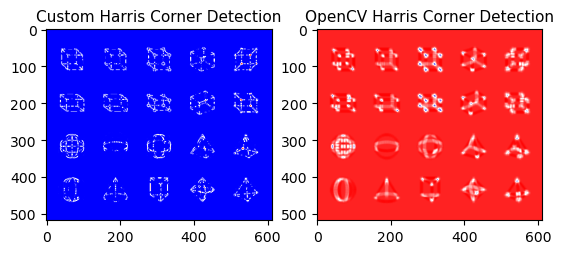

In [54]:
# Read the image
image = imread(dir+'10.jpg')
compare_results(image, 0, block_size=10, ksize=3)

##### Img 11

<class 'numpy.ndarray'>
83072001951.91975 -11930036968.378601 -152325032.0919322 0.0
[[8.27348290e+10 6.92113924e+10 4.54683628e+10 ... 4.73318410e+10
  6.99823651e+10 8.30720020e+10]
 [6.92113924e+10 5.80570978e+10 3.85199781e+10 ... 4.05799578e+10
  5.88636765e+10 6.95296774e+10]
 [4.54683628e+10 3.85199781e+10 2.60716084e+10 ... 2.80223810e+10
  3.92484369e+10 4.57290710e+10]
 ...
 [4.54683628e+10 3.85199781e+10 2.60716084e+10 ... 2.60716084e+10
  3.85199781e+10 4.54683628e+10]
 [6.92113924e+10 5.80570978e+10 3.85199781e+10 ... 3.85199781e+10
  5.80570978e+10 6.92113924e+10]
 [8.27348290e+10 6.92113924e+10 4.54683628e+10 ... 4.54683628e+10
  6.92113924e+10 8.27348290e+10]]


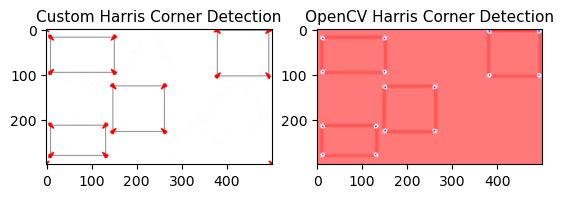

In [11]:
# Read the image
image = imread(dir+'11.jpg')
compare_results(image, 1000000, window_size=2, block_size=10, ksize=5)

##### Img 2

<class 'numpy.ndarray'>
31311541916.32213 -4653957890.466001 -138366.84795463015 10.819046222306206
[[2.76534863e+10 2.31605892e+10 1.52443391e+10 ... 1.72092891e+10
  2.61944538e+10 3.13115419e+10]
 [2.31478582e+10 1.94423965e+10 1.29271803e+10 ... 1.45835285e+10
  2.19780246e+10 2.61986678e+10]
 [1.52206023e+10 1.29143798e+10 8.76255581e+09 ... 9.87666393e+09
  1.45894479e+10 1.72183820e+10]
 ...
 [4.28155664e+09 3.63275448e+09 2.46528813e+09 ... 4.81188526e+09
  7.11594848e+09 8.40566106e+09]
 [6.51279488e+09 5.46919008e+09 3.63625689e+09 ... 7.10374896e+09
  1.07173295e+10 1.27861549e+10]
 [7.78435844e+09 6.51778362e+09 4.28932615e+09 ... 8.38231498e+09
  1.27726965e+10 1.52804609e+10]]


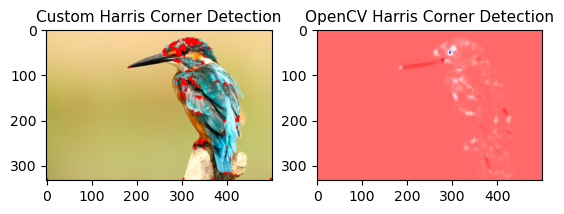

In [12]:
# Read the image
image = imread(dir+'2.jpeg')
compare_results(image, 400000000, window_size=2, block_size=10, ksize=5)

##### Img 3

<class 'numpy.ndarray'>
2225004013.92 -2229263978.6 156472544.9797394 25093568.8
[[ 1.95752610e+09  1.96960513e+09  1.96365133e+09 ...  9.93329378e+08
   1.15831035e+09  1.24779721e+09]
 [ 1.88635530e+09  1.91398582e+09  1.93775212e+09 ...  9.29374051e+08
   1.07769019e+09  1.15789160e+09]
 [ 1.72490034e+09  1.77598444e+09  1.84551153e+09 ...  8.09631361e+08
   9.28151636e+08  9.91686046e+08]
 ...
 [ 1.67868035e+09  1.56998003e+09  1.20306530e+09 ... -1.58397274e+09
  -1.52743021e+09 -1.52212574e+09]
 [ 1.79272552e+09  1.66885535e+09  1.44697704e+09 ... -1.53899593e+09
  -1.44315298e+09 -1.41770055e+09]
 [ 1.82884665e+09  1.69804775e+09  1.46404308e+09 ... -1.40068584e+09
  -1.28103248e+09 -1.41472466e+09]]


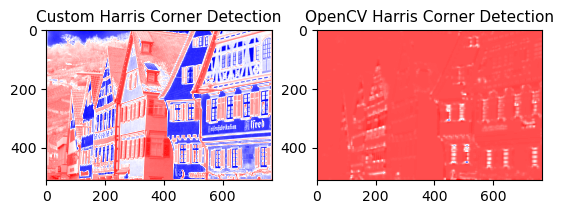

In [61]:
# Read the image
image = imread(dir+'3.png')
compare_results(image, 40000000000, window_size=3, block_size=10, ksize=5)

##### Img 5

<class 'numpy.ndarray'>
1544288128.528901 -932183109.5055331 -636389.4499240007 152.28525692017564
[[3.13710418e+07 2.59091379e+07 1.67254112e+07 ... 2.37387142e+08
  3.60073352e+08 4.29743724e+08]
 [2.59984367e+07 2.15076047e+07 1.39909898e+07 ... 2.00212440e+08
  3.00591180e+08 3.57802533e+08]
 [1.68587807e+07 1.40591641e+07 9.30168043e+06 ... 1.34480146e+08
  1.97958335e+08 2.33468730e+08]
 ...
 [6.65653614e+06 5.64662529e+06 3.83932323e+06 ... 2.78997145e+06
  4.04814606e+06 4.71270222e+06]
 [1.00799390e+07 8.45414908e+06 5.62334956e+06 ... 3.99260578e+06
  5.92576772e+06 6.98507643e+06]
 [1.20223480e+07 1.00475880e+07 6.60913123e+06 ... 4.61925268e+06
  6.93300889e+06 8.20276149e+06]]


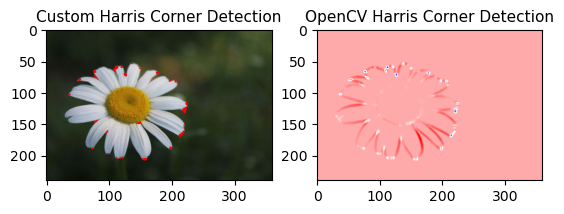

In [14]:
# Read the image
image = imread(dir+'5.jpg')
compare_results(image, 400000000, window_size=2, block_size=5, ksize=5)

##### Img 6

<class 'numpy.ndarray'>
19118033114.721027 -2711325300.341628 43665665.63601282 3853.3695968078155
[[7.57391291e+08 6.92172815e+08 5.72221323e+08 ... 5.67504199e+07
  5.49643912e+07 5.48614309e+07]
 [6.91267985e+08 6.32405749e+08 5.23993456e+08 ... 5.39107679e+07
  5.10936177e+07 5.04535711e+07]
 [5.70234493e+08 5.22853889e+08 4.35188413e+08 ... 4.78375708e+07
  4.36313361e+07 4.22536215e+07]
 ...
 [4.37232300e+07 4.00065765e+07 3.31735860e+07 ... 3.31735860e+07
  4.00065765e+07 4.37232300e+07]
 [5.30736387e+07 4.84575428e+07 4.00065765e+07 ... 4.00065765e+07
  4.84575428e+07 5.30736387e+07]
 [5.81874084e+07 5.30736387e+07 4.37232300e+07 ... 4.37232300e+07
  5.30736387e+07 5.81874084e+07]]


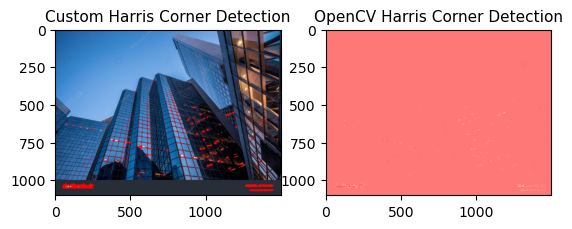

In [19]:
# Read the image
image = imread(dir+'6.jpg')
compare_results(image, 400000000, window_size=3, block_size=3, ksize=3)

##### Img 7

<class 'numpy.ndarray'>
8451575437.847089 -1298915184.0545235 5448700.214495137 46934.70086876627
[[8.40974299e+09 7.68064990e+09 6.34264028e+09 ... 6.43127129e+09
  7.74349574e+09 8.45157544e+09]
 [7.67863775e+09 7.02008509e+09 5.80991441e+09 ... 5.90426020e+09
  7.09322603e+09 7.73397500e+09]
 [6.33824729e+09 5.80745890e+09 4.82771458e+09 ... 4.92397845e+09
  5.88908234e+09 6.40681714e+09]
 ...
 [5.87239875e+09 5.35586284e+09 4.46416450e+09 ... 3.17116977e+07
  3.34324910e+07 3.39268178e+07]
 [6.83699213e+09 6.22354542e+09 5.16883381e+09 ... 3.43440042e+07
  3.62545615e+07 3.68164109e+07]
 [7.41830982e+09 6.74321037e+09 5.58520083e+09 ... 3.54361855e+07
  3.74417383e+07 3.80364543e+07]]


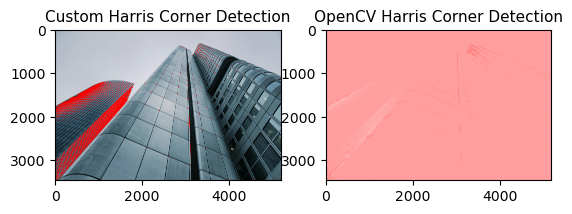

In [33]:
# Read the image
image = imread(dir+'7.jpg')
compare_results(image, 40000000, window_size=3, block_size=5, ksize=5)

##### Img 8

<class 'numpy.ndarray'>
56009533248.51396 -16985543164.938984 225763425.28530204 3807940.427094939
[[2.97176780e+09 1.93000165e+09 1.84739941e+08 ... 3.29048075e+07
  1.43640657e+07 3.11111754e+06]
 [1.31093571e+10 8.32605607e+09 1.44404247e+09 ... 2.43809892e+07
  1.08427045e+07 2.75954462e+06]
 [2.37096389e+10 1.63335043e+10 7.64388971e+09 ... 5.16735826e+06
  2.79454654e+06 1.21764166e+06]
 ...
 [6.40019911e+08 5.22116213e+08 1.91614290e+08 ... 2.19174811e+01
  1.29895006e+01 3.51199584e+00]
 [1.03308591e+09 1.02468962e+09 6.04063172e+08 ... 1.04945005e+02
  7.52890876e+01 4.15730620e+01]
 [1.45715027e+09 1.51043835e+09 9.71173108e+08 ... 1.40156120e+02
  8.66409829e+01 4.70315093e+01]]


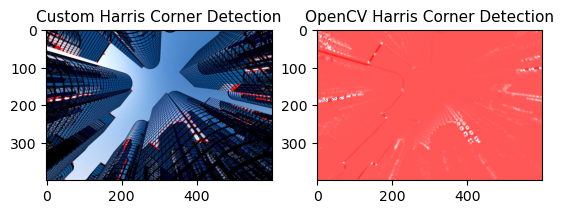

In [46]:
# Read the image
image = imread(dir+'8.jpg')
compare_results(image, 5000000000, window_size=1, block_size=6, ksize=5)

##### Img 9

<class 'numpy.ndarray'>
2653162530.0864344 -442791166.69312364 6709324.7459267 202.18346048773103
[[2.15246918e+09 2.07573942e+09 1.92859875e+09 ... 2.37447057e+09
  2.55757086e+09 2.65316253e+09]
 [2.07602910e+09 2.00233641e+09 1.86098266e+09 ... 2.28816120e+09
  2.46386587e+09 2.55557449e+09]
 [1.92937873e+09 1.86147556e+09 1.73115121e+09 ... 2.12315166e+09
  2.28481330e+09 2.36914744e+09]
 ...
 [3.21987375e+08 3.30089021e+08 3.43694975e+08 ... 8.07838781e+08
  8.44531136e+08 8.62495686e+08]
 [3.19528312e+08 3.27750980e+08 3.41583335e+08 ... 8.48706325e+08
  8.88292540e+08 9.07739050e+08]
 [3.17818609e+08 3.26085329e+08 3.40000194e+08 ... 8.68985496e+08
  9.10050735e+08 9.30254699e+08]]


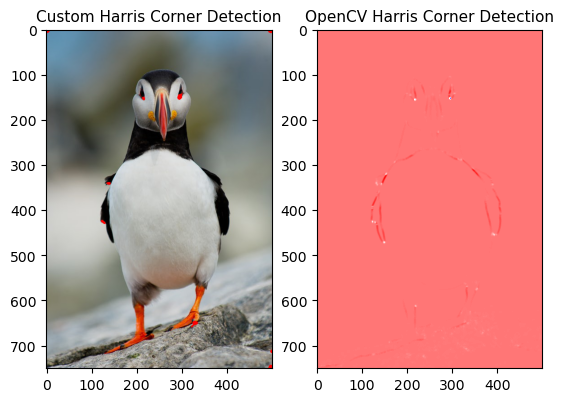

In [49]:
# Read the image
image = imread(dir+'9.jpeg')
compare_results(image, 400000000, window_size=5, block_size=5, ksize=5)

In [ ]:
# Path to the folder containing images
folder_path = 'Assignment 1/Question 1'

# Iterate through all files in the folder
for filename in os.listdir(folder_path):
    if filename.endswith(('.jpeg', '.jpg', '.gif', '.png')):
        image_path = os.path.join(folder_path, filename)
        print(f"Processing image: {filename}")
        compare_results(image_path)